# Import packages

In [66]:
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt
import PIL

import torch
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
import shutil
import os

from huggingface_hub import notebook_login
from diffusers import DiffusionPipeline, StableDiffusionPipeline
from transformers import TrainingArguments, Trainer, AutoTokenizer 

# Load data

### Load images

In [62]:
stereo_dir = '../hugging_face_images/stereo'
mono_dir = '../hugging_face_images/mono'

### Labels and descriptions of spectrograms

In [59]:
mono = pd.read_csv('description/mono.csv')
stereo = pd.read_csv('description/stereo.csv')

In [61]:
label_mono = mono['label'].tolist()
label_stereo = stereo['label'].tolist()

text_mono = mono['text'].tolist()
text_stereo = stereo['text'].tolist()

In [63]:
# add image path to dataframe which is data_dir + label
stereo['image_path'] = stereo['label'].apply(lambda x: os.path.join(stereo_dir, x))
mono['image_path'] = mono['label'].apply(lambda x: os.path.join(mono_dir, x))

In [65]:
stereo.head()

,text,label,image_path
0,The low quality recording features a ballad so...,image_0,../hugging_face_images/stereo/image_0
1,The low quality recording features a ballad so...,image_1,../hugging_face_images/stereo/image_1
2,The low quality recording features a ballad so...,image_2,../hugging_face_images/stereo/image_2
3,The low quality recording features a ballad so...,image_3,../hugging_face_images/stereo/image_3
4,This song features an electric guitar as the m...,image_4,../hugging_face_images/stereo/image_4


# Create dataloader

In [41]:
# Set the directory path of the original dataset
data_dir = '../hugging_face_images/stereo'

# Set the directory path for the new training set and testing set
train_dir = '../hugging_face_images/training_stereo/train'
test_dir = '../hugging_face_images/training_stereo/test'

# Create the train and test directories if they don't exist
if not os.path.exists(train_dir):
    os.makedirs(train_dir)

if not os.path.exists(test_dir):
    os.makedirs(test_dir)


In [9]:
# Split the dataset into train and test sets
images = [f for f in os.listdir(data_dir) if f.endswith('.jpg')]

train_images, test_images = train_test_split(images, test_size=0.3, random_state=42)

In [75]:
# create train and test labels
train_labels = [i.split('.')[0] for i in train_images]
test_labels = [i.split('.')[0] for i in test_images]

In [86]:
# create a train and test dataframe 
train_df = stereo[stereo['label'].isin(train_labels)]
test_df = stereo[stereo['label'].isin(test_labels)]

In [88]:
# reset the index
train_df.reset_index(inplace=True, drop=True)
test_df.reset_index(inplace=True, drop=True)

In [90]:
train_df.head()

,text,label,image_path
0,The low quality recording features a ballad so...,image_0,../hugging_face_images/stereo/image_0
1,The low quality recording features a ballad so...,image_1,../hugging_face_images/stereo/image_1
2,The low quality recording features a ballad so...,image_3,../hugging_face_images/stereo/image_3
3,This song features an electric guitar as the m...,image_4,../hugging_face_images/stereo/image_4
4,This song features an electric guitar as the m...,image_5,../hugging_face_images/stereo/image_5


### Moving images around

In [10]:
#  Copy the training images to the train directory
for img in train_images:
    label = img.split('_')[0]
    if not os.path.exists(os.path.join(train_dir, label)):
        os.makedirs(os.path.join(train_dir, label))
    shutil.copy(os.path.join(data_dir, img), os.path.join(train_dir, label, img))

# Copy the testing images to the test directory
for img in test_images:
    label = img.split('_')[0]
    if not os.path.exists(os.path.join(test_dir, label)):
        os.makedirs(os.path.join(test_dir, label))
    shutil.copy(os.path.join(data_dir, img), os.path.join(test_dir, label, img))


In [37]:
# move the data from ../hugging_face_images/training_stereo/train/image to ../hugging_face_images/training_stereo/train
# if .DS_Store is in the folder, remove it
def move_data(dir):
    for folder in os.listdir(dir):
        if folder == '.DS_Store':
            os.remove(os.path.join(dir, folder))
        else:
            for file in os.listdir(os.path.join(dir, folder)):
                shutil.move(os.path.join(dir, folder, file), os.path.join(dir, file))
            os.rmdir(os.path.join(dir, folder))

In [43]:
move_data(train_dir)
move_data(test_dir)

### Transforming the data

In [93]:
class TextImageDataset(Dataset):
    def __init__(self, data, tokenizer, image_transform=None):
        self.data = data
        self.tokenizer = tokenizer
        self.image_transform = image_transform
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        text_path, image_path = self.data.iloc[idx]
        text = open(text_path, "r").read()
        image = Image.open(image_path)
        if self.image_transform is not None:
            image = self.image_transform(image)
        encoded_input = self.tokenizer(text, padding="max_length", truncation=True, max_length=64, return_tensors="pt")
        input_ids = encoded_input["input_ids"].squeeze()
        attention_mask = encoded_input["attention_mask"].squeeze()
        return input_ids, attention_mask, image

In [94]:
# Load the tokenizer and define other hyperparameters
tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-base-patch32")

In [98]:
# Define the transformations to apply to the images
image_transforms = transforms.Compose([
    transforms.ToTensor(),           # convert the image to a PyTorch tensor
    transforms.Normalize(            # normalize the image pixel values
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [102]:
# Create a dataset
train_dataset = TextImageDataset(train_df, tokenizer, image_transform=image_transforms)
test_dataset = TextImageDataset(test_df, tokenizer, image_transform=image_transforms)

In [103]:
# Create a DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [101]:
train_dataloader

# Load Hugging Face model

In [16]:
notebook_login()

In [21]:
pipeline = DiffusionPipeline.from_pretrained("riffusion/riffusion-model-v1")

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
/Library/Python/3.9/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
/Library/Python/3.9/site-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:165: FutureWarning: The configuration file of the unet has set the default `sample_size` to smaller than 64 which seems highly unlikely. If your checkpoint is a fine-tuned version of any of the following: 


In [23]:
pipeline

StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.16.1",
  "feature_extractor": [
    "transformers",
    "CLIPFeatureExtractor"
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

### Use model without fine-tuning

In [32]:
prompt = "jazz music"
image = pipeline(prompt).images[0]

  0%|          | 0/50 [00:00<?, ?it/s]

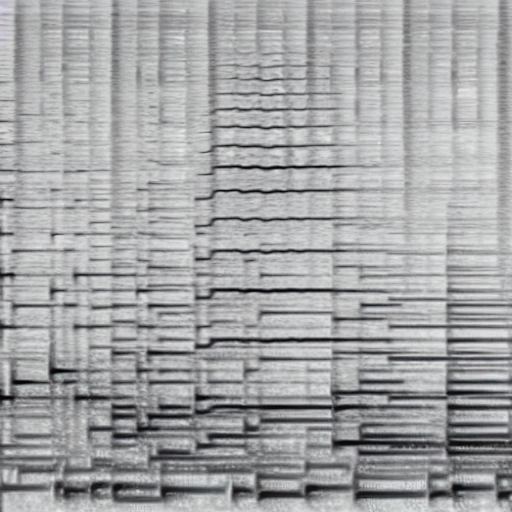

In [33]:
image

In [34]:
# save image
image.save("jazz_music.jpg")

In [121]:
prompt1 = "typewriter morphing into blues music"
image1 = pipeline(prompt1).images[0]

  0%|          | 0/50 [00:00<?, ?it/s]

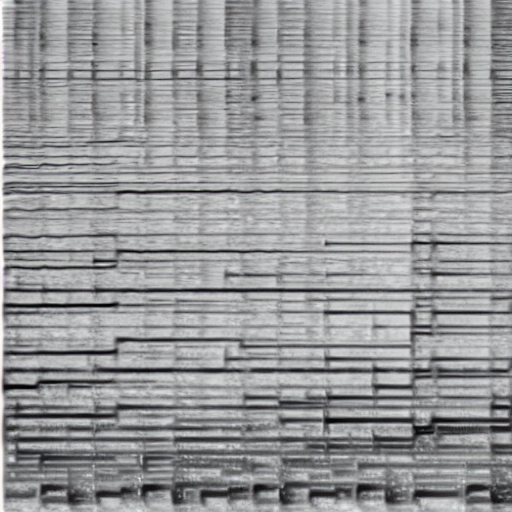

In [122]:
image1

In [123]:
# save image
image1.save("rap.jpg")

### Fine-tuning the model

In [114]:
from transformers import CLIPTextModel, CLIPFeatureExtractor

In [115]:
# Load the tokenizer and the CLIP models
tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-base-patch32")
text_model = CLIPTextModel.from_pretrained("openai/clip-vit-base-patch32")
image_model = CLIPFeatureExtractor.from_pretrained("openai/clip-vit-base-patch32")

Some weights of the model checkpoint at openai/clip-vit-base-patch32 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.8.self_attn.q_proj.weight', 'vision_model.encoder.layers.6.mlp.fc1.bias', 'vision_model.encoder.layers.0.layer_norm2.weight', 'vision_model.encoder.layers.10.self_attn.q_proj.bias', 'vision_model.encoder.layers.10.self_attn.q_proj.weight', 'vision_model.encoder.layers.7.mlp.fc2.weight', 'vision_model.encoder.layers.9.mlp.fc1.weight', 'vision_model.encoder.layers.1.self_attn.out_proj.bias', 'vision_model.encoder.layers.5.layer_norm2.bias', 'vision_model.encoder.layers.1.self_attn.q_proj.bias', 'vision_model.encoder.layers.0.self_attn.q_proj.bias', 'vision_model.encoder.layers.0.self_attn.v_proj.weight', 'vision_model.encoder.layers.0.layer_norm1.weight', 'vision_model.encoder.layers.8.layer_norm1.weight', 'vision_model.encoder.layers.5.self_attn.q_proj.bias', 'vision_model.encoder.layers.4.self_attn.v_proj.weight', 'vision_model.encoder.layers

/Library/Python/3.9/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


In [29]:
# if GPU set device to GPU else CPU
if torch.cuda.is_available():
    device = torch.device("cuda")

In [30]:
model = pipeline.to(device)

In [120]:
print(dir(model))

['__call__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_deprecated_kwargs', '_dict_from_json_file', '_encode_prompt', '_execution_device', '_get_init_keys', '_get_lora_layer_attribute', '_get_signature_keys', '_internal_dict', '_maybe_convert_prompt', '_modify_text_encoder', '_optional_components', 'check_inputs', 'components', 'config', 'config_name', 'decode_latents', 'device', 'disable_attention_slicing', 'disable_vae_slicing', 'disable_vae_tiling', 'disable_xformers_memory_efficient_attention', 'download', 'enable_attention_slicing', 'enable_model_cpu_offload', 'enable_sequential_cpu_offload', 'enable_vae_slicing', 'enable_vae_tiling', 'enable_xformers_memory_efficient_

In [118]:
# Freeze the visual and transformer parameters of the CLIPModel
for param in model.clip_model.visual.parameters():
    param.requires_grad = False

for param in model.clip_model.transformer.parameters():
    param.requires_grad = False

AttributeError: 'StableDiffusionPipeline' object has no attribute 'clip_model'

In [107]:
# Unfreeze the last 10 layers of the encoder
for name, param in model.unet.named_parameters():
    if name.startswith('encoder') and int(name.split('.')[1]) > 4:
        param.requires_grad = True

In [111]:
# Unfreeze the last 10 layers of the encoder in the VAE
vae_encoder_layers = list(model.vae.encoder.children())
num_unfrozen_layers = 10
for i in range(len(vae_encoder_layers) - num_unfrozen_layers, len(vae_encoder_layers)):
    for param in vae_encoder_layers[i].parameters():
        param.requires_grad = True

In [112]:
# Define hyperparameters
batch_size = 64
learning_rate = 1e-4
num_epochs = 10

In [119]:
# Set up the optimizer and the loss function
optimizer = torch.optim.Adam(pipeline.parameters(), lr=learning_rate)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the model
for epoch in range(num_epochs):
    for i, batch in enumerate(train_dataloader):
        # Extract the input ids, attention masks, and images from the batch
        input_ids, attention_mask, images = batch
        # Move the data to the GPU if available
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        images = images.to(device)
        # Compute the predictions
        outputs = pipeline(text=input_ids, image=images)
        # Compute the loss
        loss = loss_fn(outputs, labels)
        # Zero out the gradients
        optimizer.zero_grad()
        # Backpropagate the gradients
        loss.backward()
        # Update the parameters
        optimizer.step()
        
        # Print the loss and the iteration number every 10 iterations
        if i % 10 == 0:
            print(f"Epoch {epoch}, iteration {i}, loss: {loss.item()}")

AttributeError: 'StableDiffusionPipeline' object has no attribute 'parameters'

In [32]:
# Set up the training configuration
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=10,             # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
)

In [34]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=test_data,
)

In [35]:
trainer.train()

AttributeError: 'StableDiffusionPipeline' object has no attribute 'forward'

In [31]:
pipeline.run(train_data, num_steps=1000, eval_steps=100)

AttributeError: 'StableDiffusionPipeline' object has no attribute 'run'

In [25]:
# Train the model on your data
trainer = pipeline.get_trainer(training_args=training_args)
trainer.train(train_data)

AttributeError: 'StableDiffusionPipeline' object has no attribute 'get_trainer'

# Modify model to alterate audio input